# ClusterAI 2020
# Ciencia de Datos - Ingeniería Industrial - UTN BA
# clase_07: Practica Clustering: Wine Data Set
### Elaborado por: Nicolás Aguirre

# Importamos Librerias

In [1]:
# importamos las librerías necesarias para trabajar.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn import preprocessing

In [2]:
# Importamos librerias de PCA y silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [3]:
# Importamos librerias de Clustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import AgglomerativeClustering

# Repositorio del Dataset
## Wine Data Set:

https://archive.ics.uci.edu/ml/datasets/Wine

# Importamos Dataset

In [4]:
names_col = ['G','Alcohol','Malic acid','Ash','Alcalinity of ash','Magnesium','Total phenols',
             'Flavanoids','Nonflavanoid phenols','Proanthocyanins','Color intensity','Hue',
             'OD280/OD315 of diluted wines','Proline']

wine_df = pd.read_csv('../../datasets/vinos/clusterai2020_clase07_wine.data', delimiter=',', names=names_col)

In [5]:
wine_df.head()

,G,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [6]:
wine_df.shape

(178, 14)

In [7]:
wine_df.isnull().sum()

G                               0
Alcohol                         0
Malic acid                      0
Ash                             0
Alcalinity of ash               0
Magnesium                       0
Total phenols                   0
Flavanoids                      0
Nonflavanoid phenols            0
Proanthocyanins                 0
Color intensity                 0
Hue                             0
OD280/OD315 of diluted wines    0
Proline                         0
dtype: int64

In [8]:
# Definimos nuestro X
x = wine_df.iloc[:,1:]
display(x.head())
print(x.shape)

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


(178, 13)


In [9]:
# Vamos a crear un dataframe para guardar los resultados
results_df = pd.DataFrame(columns=['Cluster','Acc','Sill'])

# Auto-Scaling

In [10]:
# Realizamos un autoscaling con los datos, para todas las features
scaler = preprocessing.StandardScaler().fit(x)

In [11]:
xscal = scaler.transform(x)

In [12]:
xscal

array([[ 1.51861254, -0.5622498 ,  0.23205254, ...,  0.36217728,
         1.84791957,  1.01300893],
       [ 0.24628963, -0.49941338, -0.82799632, ...,  0.40605066,
         1.1134493 ,  0.96524152],
       [ 0.19687903,  0.02123125,  1.10933436, ...,  0.31830389,
         0.78858745,  1.39514818],
       ...,
       [ 0.33275817,  1.74474449, -0.38935541, ..., -1.61212515,
        -1.48544548,  0.28057537],
       [ 0.20923168,  0.22769377,  0.01273209, ..., -1.56825176,
        -1.40069891,  0.29649784],
       [ 1.39508604,  1.58316512,  1.36520822, ..., -1.52437837,
        -1.42894777, -0.59516041]])

# K-MEANS

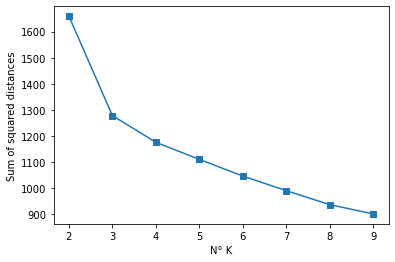

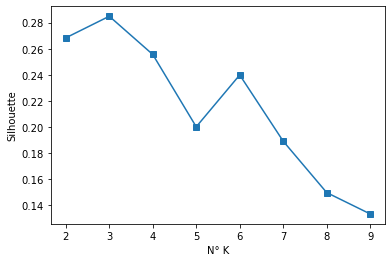

In [13]:
dist_cent = []
sill_list = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(xscal)
    sill_score = silhouette_score(xscal,kmeans.labels_)
    sill_list.append(sill_score)
    dist_cent.append(kmeans.inertia_)
plt.plot(range(2, 10), dist_cent, marker='s');
plt.xlabel('N° K')
plt.ylabel('Sum of squared distances')
plt.show()
plt.plot(range(2, 10), sill_list, marker='s');
plt.xlabel('N° K')
plt.ylabel('Silhouette')
plt.show()


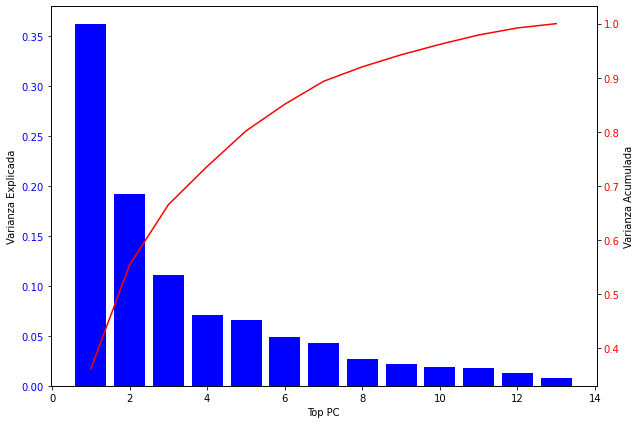

In [14]:
# Generamos un PCA con los datos luego del autoscaling
import matplotlib.cm as cm
from sklearn import decomposition

# Usamos el objeto PCA de la libreria 'decomposition'
# Definimos la cantidad de componentes
n_comps = 13
components = range(1,n_comps + 1) 
pca = decomposition.PCA(n_components=n_comps)

# Ajustamos
pca.fit(xscal)

# Transformamos
xpca = pca.transform(xscal)

# Porcentaje de la varianza explicada por cada PC
eigenvalues = pca.explained_variance_ratio_

# Suma acumulada
eigenvalues_acum = pca.explained_variance_ratio_.cumsum() 

# Graficamos
# Eje Izquierdo
fig, ax1 = plt.subplots(figsize=(9,6))
ax1.set_xlabel('Top PC')
ax1.set_ylabel('Varianza Explicada', color='k')
ax1.bar(components, eigenvalues, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Eje derecho
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Varianza Acumulada', color='k') 
ax2.plot(components, eigenvalues_acum, color='red') 
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [15]:
# De la libreria:
# 'Principal axes in feature space, representing the directions of maximum variance in the data'
# The components are sorted by explained_variance_
pd.DataFrame(pca.components_[0:n_comps,:],columns=x.columns)

# En criollo:
# Es la direccion de los ejes de cada componente (autovectores)

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,0.144329,-0.245188,-0.002051,-0.239320,0.141992,0.394661,0.422934,-0.298533,0.313429,-0.088617,0.296715,0.376167,0.286752
1,-0.483652,-0.224931,-0.316069,0.010591,-0.299634,-0.065040,0.003360,-0.028779,-0.039302,-0.529996,0.279235,0.164496,-0.364903
2,-0.207383,0.089013,0.626224,0.612080,0.130757,0.146179,0.150682,0.170368,0.149454,-0.137306,0.085222,0.166005,-0.126746
3,-0.017856,0.536890,-0.214176,0.060859,-0.351797,0.198068,0.152295,-0.203301,0.399057,0.065926,-0.427771,0.184121,-0.232071
4,-0.265664,0.035214,-0.143025,0.066103,0.727049,-0.149318,-0.109026,-0.500703,0.136860,-0.076437,-0.173615,-0.101161,-0.157869
5,-0.213539,-0.536814,-0.154475,0.100825,-0.038144,0.084122,0.018920,0.258594,0.533795,0.418644,-0.105983,-0.265851,-0.119726
6,-0.056396,0.420524,-0.149171,-0.286969,0.322883,-0.027925,-0.060685,0.595447,0.372139,-0.227712,0.232076,-0.044764,0.076805
7,-0.396139,-0.065827,0.170260,-0.427970,0.156361,0.405934,0.187245,0.233285,-0.368227,0.033797,-0.436624,0.078108,-0.120023
8,0.508619,-0.075283,-0.307694,0.200449,0.271403,0.286035,0.049578,0.195501,-0.209145,0.056218,0.085828,0.137227,-0.575786
9,0.211605,-0.309080,-0.027125,0.052799,0.067870,-0.320131,-0.163151,0.215535,0.134184,-0.290775,-0.522399,0.523706,0.162116


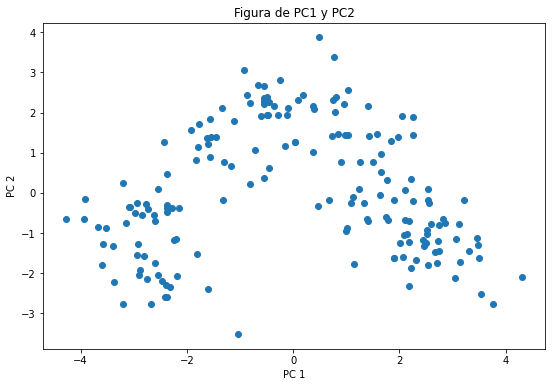

In [16]:
# scatter plot de los datos, solamente con 2 PC
plt.figure(figsize=(9,6))
plt.scatter(xpca[:,0],xpca[:,1])    
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Figura de PC1 y PC2')
plt.show()

In [17]:
# Generamos un modelo de K means con 3 clusters con los datos autoscalados
kmeans = KMeans(n_clusters=3, random_state=10).fit(xscal)

**Pregunta: Como se define el numero de cluster del Kmean?**

In [18]:
# una vez realizado el clusering, observamos los labels de cluster asignadas a cada muestra
kmeans.labels_ = kmeans.labels_+1
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3], dtype=int32)

In [21]:
# visualizamos los centroides finales de cada cluster
centers = kmeans.cluster_centers_
centers

array([[ 0.83523208, -0.30380968,  0.36470604, -0.61019129,  0.5775868 ,
         0.88523736,  0.97781956, -0.56208965,  0.58028658,  0.17106348,
         0.47398365,  0.77924711,  1.12518529],
       [-0.92607185, -0.39404154, -0.49451676,  0.17060184, -0.49171185,
        -0.07598265,  0.02081257, -0.03353357,  0.0582655 , -0.90191402,
         0.46180361,  0.27076419, -0.75384618],
       [ 0.16490746,  0.87154706,  0.18689833,  0.52436746, -0.07547277,
        -0.97933029, -1.21524764,  0.72606354, -0.77970639,  0.94153874,
        -1.16478865, -1.29241163, -0.40708796]])

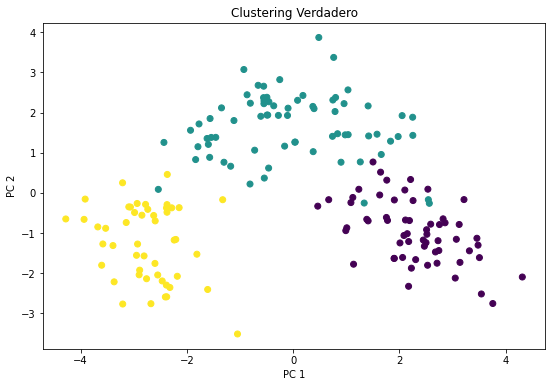

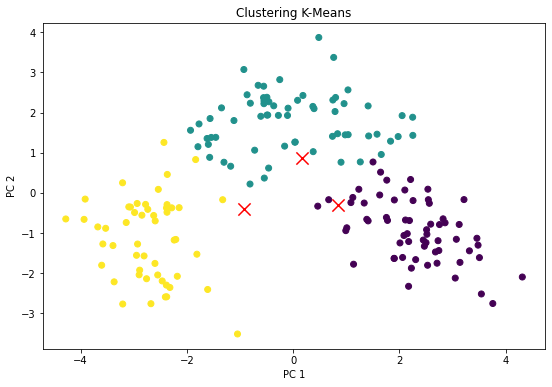

In [22]:
# Scatter plot de muestras y centroides con 2 PC: segun Cluster verdadero vs Clustering con K-Means

#Verdadero
plt.figure(figsize=(9,6))
plt.scatter(xpca[:,0],xpca[:,1],c=wine_df['G'].astype(float))    
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Clustering Verdadero')
# K-Means
plt.figure(figsize=(9,6))
plt.scatter(xpca[:,0],xpca[:,1],c=kmeans.labels_.astype(float))
plt.scatter(centers[:,0], centers[:,1], marker="x", color='r',s=150)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Clustering K-Means')
plt.show()

**PREGUNTA:**

**¿Son correctos los centroides?**

### Metricas del Kmeans

In [23]:
# Metricas
# Cantidad de errores
q_wrong = kmeans.labels_ - wine_df['G']
q_wrong = (q_wrong!=0).sum()
print(q_wrong)
#Accuracy
acc = ( x.shape[0] - q_wrong ) / x.shape[0]
#Sill. score
sill_score = silhouette_score(xscal,kmeans.labels_)
print(acc)
print(sill_score)

6
0.9662921348314607
0.2848589191898987


In [24]:
#Guardamos los resultados
results_df = results_df.append({'Cluster':'Kmeans',
                                'Acc':acc,
                                'Sill':sill_score},ignore_index=True)


# Reduccion de Dimensionalidad (RD) + K-Means

Ahora vamos dejar de usar las 13 variables originales.

Vamos a clusterizar con lo que nos puedan explicar UNICAMENTE los primeros 2 PC, y compararemos los resultados.

In [25]:
reduced_dim = 2
xpca_rd = xpca[:,0:reduced_dim]

In [27]:
# Generamos el modelo K-means + RD
kmeans_rd = KMeans(n_clusters=3, random_state=10).fit(xpca_rd)

In [28]:
# una vez realizado el clusering, observamos las labels de cluster asignadas a cada muestra
kmeans_rd.labels_ = kmeans_rd.labels_ +1
kmeans_rd.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3], dtype=int32)

In [29]:
# visualizamos los centroides finales de cada cluster
centers_rd = kmeans_rd.cluster_centers_
centers_rd

array([[ 2.26614991, -0.86559213],
       [-0.16278513,  1.76758824],
       [-2.74392982, -1.2141906 ]])

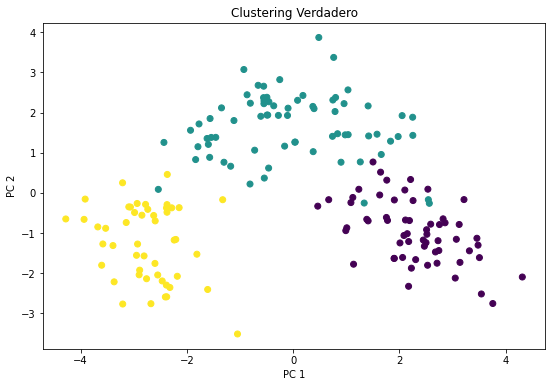

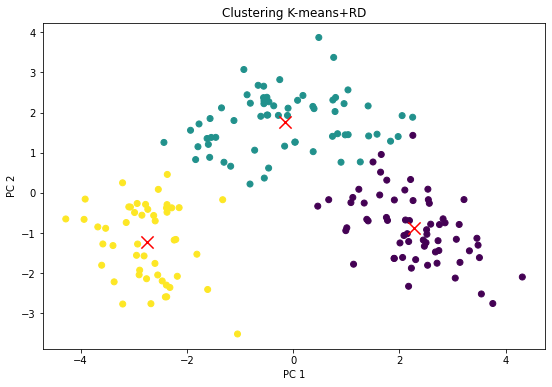

In [30]:
# Scatter plot con 2 PC: segun Cluster verdadero vs Clustering con K-Means+RD

#Verdadero
plt.figure(figsize=(9,6))
plt.scatter(xpca[:,0],xpca[:,1],c=wine_df['G'].astype(float))    
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Clustering Verdadero')
# K-Means + RD
plt.figure(figsize=(9,6))
plt.scatter(xpca_rd[:,0],xpca_rd[:,1],c=kmeans_rd.labels_.astype(float))
plt.scatter(centers_rd[:,0], centers_rd[:,1], marker="x", color='r',s=150)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Clustering K-means+RD')
plt.show()

**PREGUNTA:**

**¿Y aca que sucedió?**

### Metricas RD + K-Means

In [31]:
# Metricas
q_wrong = kmeans_rd.labels_ - wine_df['G']
q_wrong = (q_wrong!=0).sum()
print(q_wrong)
acc_rd = ( x.shape[0] - q_wrong ) / x.shape[0]

sill_score_rd = silhouette_score(xpca_rd,kmeans_rd.labels_)

print(acc_rd)
print(sill_score_rd)

6
0.9662921348314607
0.5610505693103245


In [32]:
#Guardamos los resultados
results_df = results_df.append({'Cluster':'PCA + Kmeans',
                                'Acc':acc_rd,
                                'Sill':sill_score_rd},ignore_index=True)

In [33]:
pd.DataFrame(pca.components_[0:reduced_dim,:],columns=x.columns)

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,0.144329,-0.245188,-0.002051,-0.239320,0.141992,0.394661,0.422934,-0.298533,0.313429,-0.088617,0.296715,0.376167,0.286752
1,-0.483652,-0.224931,-0.316069,0.010591,-0.299634,-0.065040,0.003360,-0.028779,-0.039302,-0.529996,0.279235,0.164496,-0.364903


## Recontrusccion

**Si quisieramos volver a nuestro espacio original, consideremos que:**

X = PCAvalores * PCAdirecciones

X = PCAscores * PCAcomponents 

X = Autovalores * Autovectores

Solo nos quedaria un detalle. Sumar la media de X.

**¿POR QUE?**

X = Autovalores * Autovectores + Xmedia

**Entonces:**

X_reconstruida = Autovalores(n_componentes) * Autovectores(n_componentes) + Xmedia

In [34]:
mu = np.mean(x, axis=0)
# 2 PCA
xpca_rd = xpca[:,0:reduced_dim]
x_reconstruido = np.dot(xpca_rd, pca.components_[0:reduced_dim,:])
x_reconstruido += mu
x_reconstruido_df = pd.DataFrame(x_reconstruido,columns=x.columns)

# Muestramos la reconstruccion
sample = np.random.randint(0,high=x.shape[0])
display(x.iloc[sample,:].to_frame().transpose())
display(x_reconstruido_df.iloc[sample,:].to_frame().transpose())

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
35,13.48,1.81,2.41,20.5,100.0,2.7,2.98,0.26,1.86,5.1,1.04,3.47,920.0


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
35,13.360863,1.909302,2.418465,19.037448,100.06485,3.057971,2.833869,-0.201416,2.194559,4.983035,1.472998,3.298774,747.503667


## Consultas?

# Clustering Jerárquico

In [35]:
# Definimos el linkage
Z = linkage(xscal, 'ward')

In [40]:
# Threshold (Similaridad)
dist_cluster = 4

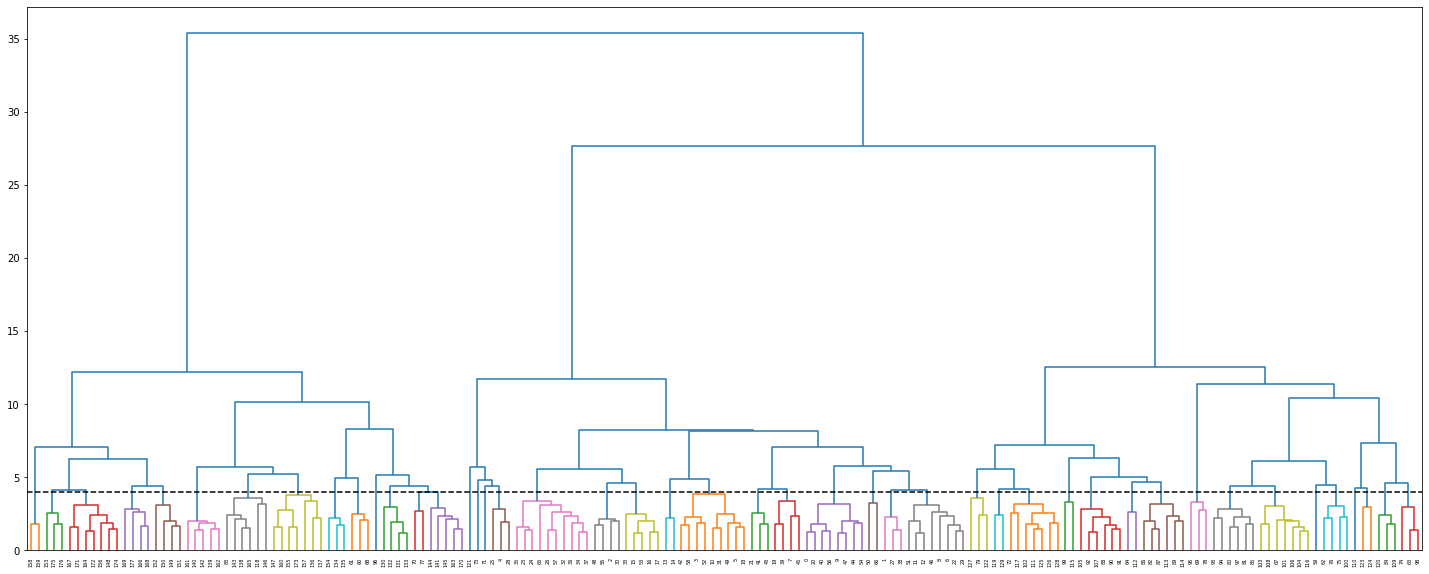

In [41]:
plt.figure(figsize=(25, 10))
dendrogram(Z,color_threshold=dist_cluster)
plt.axhline(c='k',linestyle='--', y=dist_cluster)
plt.show()

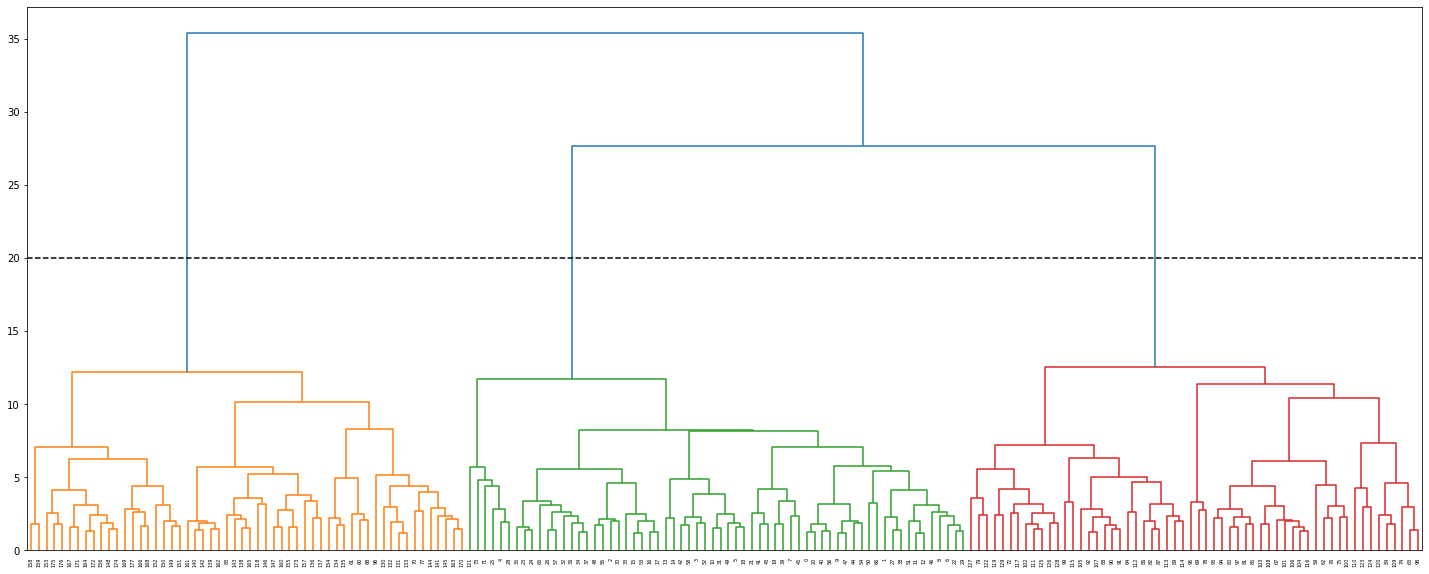

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 2, 1, 1, 1, 3,
       3, 1, 2, 1, 2, 3, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [46]:
#dist_cluster = ?
#q_clusters = 5

dist_cluster = 20
plt.figure(figsize=(25, 10))
dendrogram(Z,color_threshold=dist_cluster)
plt.axhline(c='k',linestyle='--', y=dist_cluster)
plt.show()

cluster = AgglomerativeClustering(n_clusters=None, distance_threshold =dist_cluster,
                                  affinity='euclidean',
                                  linkage='ward')
cluster.fit_predict(xscal)
cluster.labels_= cluster.labels_+1
cluster.labels_

### SOLO PORQUE SABEMOS EL GROUND TRUE DE LOS CLUSTERS LOS AJUSTO MANUALENTE PARA CALCULAR EL ACCURACY ! !

In [47]:
for i in np.arange(0,x.shape[0]):
    if cluster.labels_[i]==3:
        cluster.labels_[i]=1
    elif cluster.labels_[i]==2:
        cluster.labels_[i]=3
    elif cluster.labels_[i]==1:
        cluster.labels_[i]=2

In [48]:
cluster.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 2, 2, 2, 1,
       1, 2, 3, 2, 3, 1, 2, 1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3])

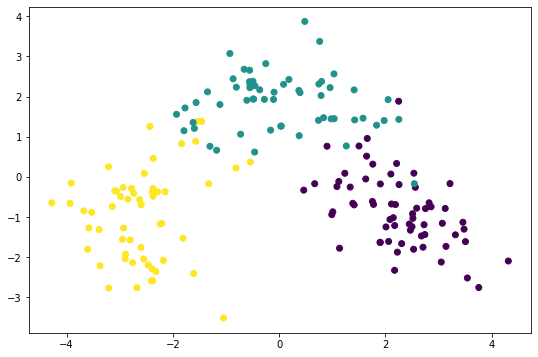

In [49]:
plt.figure(figsize=(9, 6))
plt.scatter(xpca[:,0], xpca[:,1], c=cluster.labels_,)
plt.show()

In [50]:
# Metricas
q_wrong = cluster.labels_ - wine_df['G']
q_wrong = (q_wrong!=0).sum()
print(q_wrong)
acc3 = ( x.shape[0] - q_wrong ) / x.shape[0]
sill_score_h = silhouette_score(xscal,cluster.labels_)

print(acc3)
print(sill_score_h)

13
0.9269662921348315
0.27744398269522647


In [51]:
#Guardamos los resultados
results_df = results_df.append({'Cluster':'Hierarchy',
                                'Acc':acc3,
                                'Sill':sill_score_h},ignore_index=True)

# Resultados

In [52]:
display(results_df)

,Cluster,Acc,Sill
0,Kmeans,0.966292,0.284859
1,PCA + Kmeans,0.966292,0.561051
2,Hierarchy,0.926966,0.277444


# Preguntas ?